<h1><bold>
Indexing - Global Descriptors </bold>

----
<h2>1	Introduction</h2>

The objective of this notebook is to introduce Content-Based Image Retrieval (CBIR) systems. CBIR enables the search for images similar to a query image within a database of images. This similarity is not calculated directly on the images themselves but through a descriptor chosen by the system designer. The figure below provides an overview of a CBIR system..



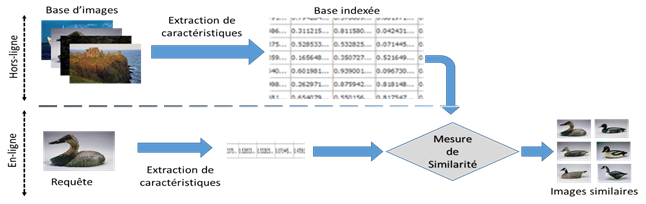

A CBIR system is organized into two phases:
1. Offline phase, often referred to as indexing, during which a descriptor vector is extracted for each image and stored in the form of an index database.
2. Online phase, often referred to as retrieval, during which the system searches for images similar to a query image. The same type of descriptor is extracted from the query image and compared to the index database.



Two parameters must be considered when developing a CBIR system:"
The **descriptors** (also called features) used **to create the index database**, and the **similarity measure** used to find the most similar images to a query image. Thus, the search is performed by measuring the distance between descriptors rather than between the images themselves.
<br>
<br>
The descriptors used here to create the index database are **low-level global descriptors, such as shape, color, and texture**. The similarity measure can be as simple as the **Euclidean distance**.

<h2>2	Database</h2>
We will use a subset of the COREL image database. The COREL database contains 10,800 images classified into 80 groups. This database is ideal for understanding the fundamentals of CBIR. Here, we will use only 270 images belonging to two image groups, which are grouped into a single folder.

<h2>3	Indexing</h2>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


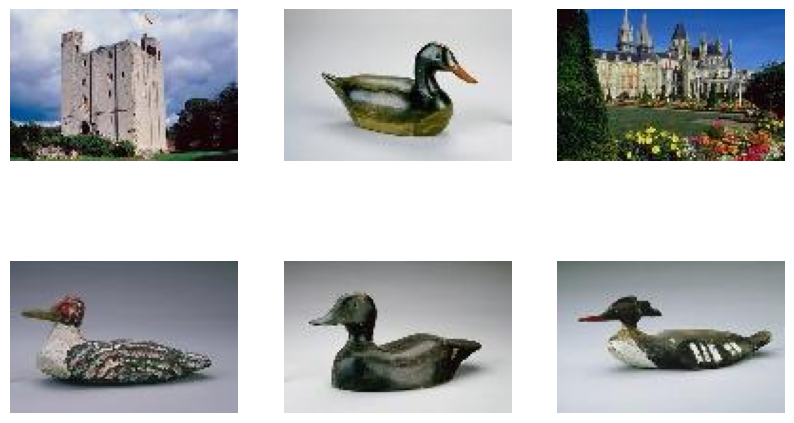

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

base_image_path = '/content/drive/My Drive/CBIR_DataSet/obj_decoys/'

all_images = [os.path.join(base_image_path, file) for file in os.listdir(base_image_path) if file.endswith(('jpg', 'jpeg', 'png'))]

sample_images = random.sample(all_images, 6)

plt.figure(figsize=(10, 6))
for i, image_path in enumerate(sample_images):
    img = Image.open(image_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


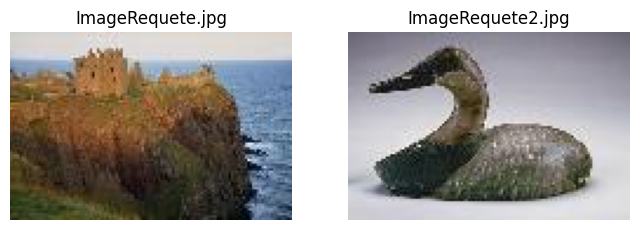

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

query_image_path = '/content/drive/My Drive/CBIR_DataSet/img_requetes/'

query_images = [os.path.join(query_image_path, file) for file in os.listdir(query_image_path) if file.endswith(('jpg', 'jpeg', 'png'))]

plt.figure(figsize=(8, 4))
for i, image_path in enumerate(query_images[:2]):
    img = Image.open(image_path)
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.show()

<h2>3.1	Search by Entire Image</h2>

For a first implementation of a CBIR system, the objective is to display the 5 most similar images to the query image "ImageRequete.jpg," based on a calculation of differences between entire images.

1. Use the Euclidean distance between the query image and all the images in the database. The distances will be stored in a dictionary and then sorted in ascending order.
2.Display the query image along with the 5 most similar images in terms of Euclidean distance. Interpret the results.

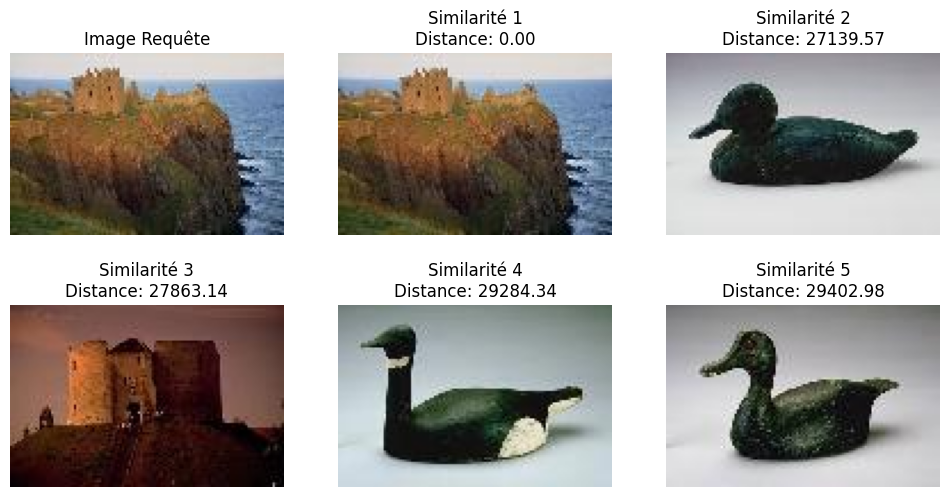

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances

def image_to_vector(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))
    return np.array(img).flatten()
query_image_path = '/content/drive/My Drive/CBIR_DataSet/img_requetes/ImageRequete.jpg'

base_image_path = '/content/drive/My Drive/CBIR_DataSet/obj_decoys/'

base_images = [os.path.join(base_image_path, file) for file in os.listdir(base_image_path) if file.endswith(('jpg', 'jpeg', 'png'))]

query_vector = image_to_vector(query_image_path)

distances = {}

for image_path in base_images:
    base_vector = image_to_vector(image_path)
    dist = np.linalg.norm(query_vector - base_vector)
    distances[image_path] = dist

sorted_images = sorted(distances.items(), key=lambda x: x[1])


plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
query_image = Image.open(query_image_path)
plt.imshow(query_image)
plt.title("Image Requête")
plt.axis('off')

for i, (image_path, distance) in enumerate(sorted_images[:5]):
    plt.subplot(2, 3, i + 2)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Similarité {i+1}\nDistance: {distance:.2f}")
    plt.axis('off')

plt.show()

This method is based solely on **raw pixel differences** and **does not consider more complex features such as structure, object shape, texture, or the semantics of the image**. As a result, it may sometimes fail to capture visual similarities that are obvious to the human eye.

The returned images include a mix of architectural scenes and objects (ducks), with distances varying significantly.

1. **Correct similarity with buildings:** The similar image representing another castle (Similarity 3) shows that the system sometimes captures structural similarities.
2. **Inconsistent results with ducks:** The appearance of ducks in the results (Similarity 2, 4, and 5) highlights a limitation of the method, which primarily relies on colors (green and brown) without considering structure or visual context.

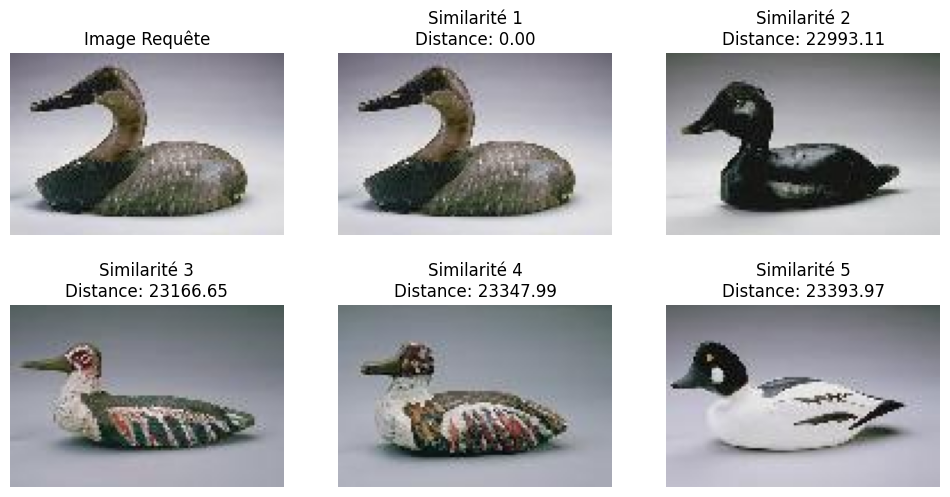

In [ ]:
query_image_path2 = '/content/drive/My Drive/CBIR_DataSet/img_requetes/ImageRequete2.jpg'

base_images = [os.path.join(base_image_path, file) for file in os.listdir(base_image_path) if file.endswith(('jpg', 'jpeg', 'png'))]

query_vector = image_to_vector(query_image_path2)

distances = {}

for image_path in base_images:
    base_vector = image_to_vector(image_path)
    dist = np.linalg.norm(query_vector - base_vector)
    distances[image_path] = dist

sorted_images = sorted(distances.items(), key=lambda x: x[1])

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
query_image = Image.open(query_image_path2)
plt.imshow(query_image)
plt.title("Image Requête")
plt.axis('off')

for i, (image_path, distance) in enumerate(sorted_images[:5]):
    plt.subplot(2, 3, i + 2)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Similarité {i+1}\nDistance: {distance:.2f}")
    plt.axis('off')

plt.show()

1. The performance is better here when using the duck query image.
2. SO we have a good performance on similar objects: the system works correctly when the **query images and the database contain almost identical objects**.

<h2>3.2	Color-Based Search</h2>
In this section, the color feature will be used to develop our CBIR system. The search is performed based on the similarity between the features of the query image and those of the indexed database. The color descriptor vector to be used consists of the statistical moments: m**ean and variance for each color component. The vector size will therefore be 6.**
<br>
<br>
The code should first index the image database and then perform the search for a query image, displaying the 5 most similar images.

The code will include two parts:<br>
1. Indexing part: The CBIR_Indexation function is called with the descriptor vector size as a parameter. This part should only be executed once.<br>
2. Search part: The CBIR_Recherche function is called with the query image, the descriptor matrix, and the corresponding image names as parameters.<br>
<br>
**The descriptor vector is created by the getFeatures function**, which takes the image and vector size as arguments. This function will later be modified to add additional descriptors. It currently calls the **color_Moments function**, which **returns the 6 color moments.**


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def color_Moments(img):
    img_array = np.array(img)

    R = img_array[:, :, 0].flatten()
    G = img_array[:, :, 1].flatten()
    B = img_array[:, :, 2].flatten()

    moments = []
    for channel in [R, G, B]:
        mean = np.mean(channel)
        variance = np.var(channel)
        moments.extend([mean, variance])

    return np.array(moments)
def getFeatures(img, fsize=6):
    return color_Moments(img)

def CBIR_Indexation(base_image_path, fsize=6):
    index_matrix = []
    image_names = []

    for image_file in os.listdir(base_image_path):
        if image_file.endswith(('jpg', 'jpeg', 'png')):
            image_path = os.path.join(base_image_path, image_file)
            img = Image.open(image_path).convert('RGB')
            features = getFeatures(img, fsize)
            index_matrix.append(features)
            image_names.append(image_file)

    return np.array(index_matrix), image_names

def CBIR_Recherche(image_requete, index_matrix, image_names, fsize=6):
    img_req = Image.open(image_requete).convert('RGB')
    query_features = getFeatures(img_req, fsize)

    distances = []
    for i, features in enumerate(index_matrix):
        dist = np.linalg.norm(query_features - features)
        distances.append((image_names[i], dist))

    distances = sorted(distances, key=lambda x: x[1])

    return distances[:5]

def afficher_resultats(image_requete, resultats, base_image_path):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    img_req = Image.open(image_requete)
    plt.imshow(img_req)
    plt.title("Image Requête")
    plt.axis('off')

    for i, (image_name, dist) in enumerate(resultats):
        img_path = os.path.join(base_image_path, image_name)
        img = Image.open(img_path)
        plt.subplot(2, 3, i + 2)
        plt.imshow(img)
        plt.title(f"Similarité {i+1}\nDistance: {dist:.2f}")
        plt.axis('off')

    plt.show()


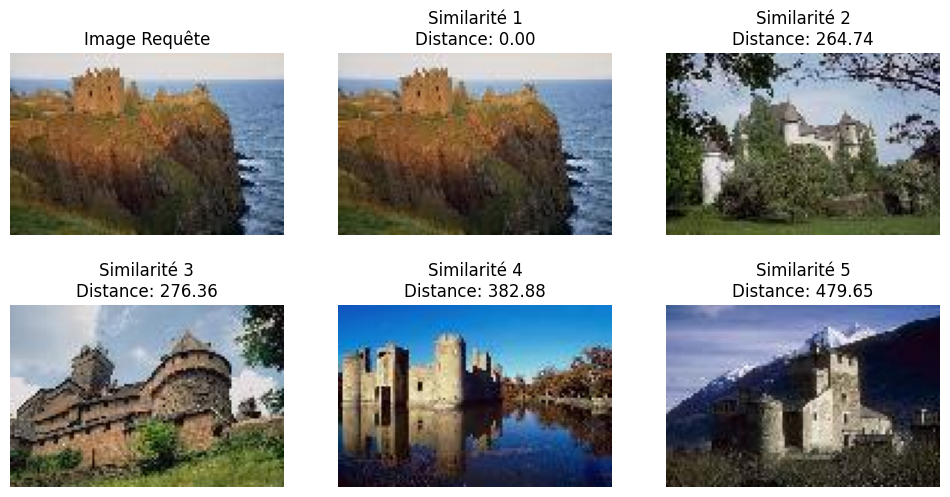

In [ ]:
base_image_path = '/content/drive/My Drive/CBIR_DataSet/obj_decoys/'

image_requete = '/content/drive/My Drive/CBIR_DataSet/img_requetes/ImageRequete.jpg'

index_matrix, image_names = CBIR_Indexation(base_image_path)

resultats = CBIR_Recherche(image_requete, index_matrix, image_names)

afficher_resultats(image_requete, resultats, base_image_path)


* **Interprétation des résultats**





Good performance for images with similar color palettes. The system identifies visually similar structures primarily based on natural colors (green, brown, blue).
**However**, this approach ignores differences in structure or context (water, mountains).


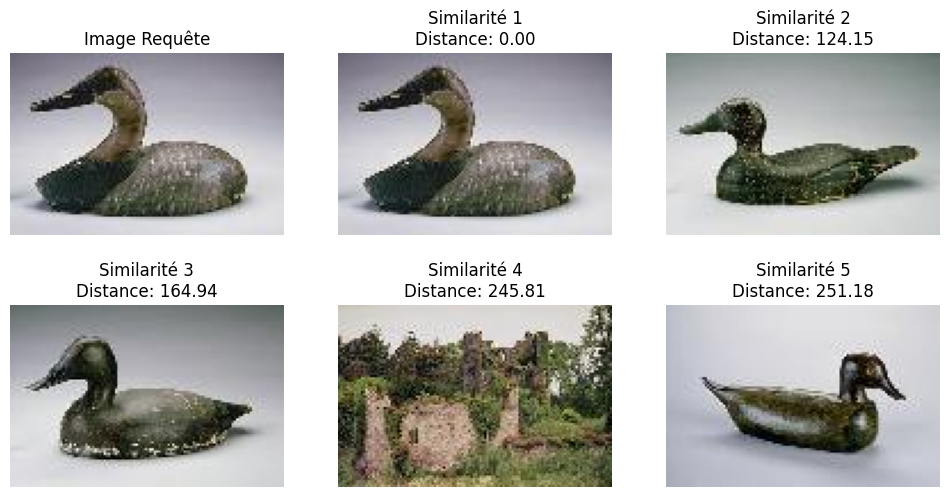

In [ ]:
base_image_path = '/content/drive/My Drive/CBIR_DataSet/obj_decoys/'

image_requete2 = '/content/drive/My Drive/CBIR_DataSet/img_requetes/ImageRequete2.jpg'

index_matrix, image_names = CBIR_Indexation(base_image_path)

resultats = CBIR_Recherche(image_requete2, index_matrix, image_names)

afficher_resultats(image_requete2, resultats, base_image_path)


* **Interprétation des résultats**





**Semantic errors:** The fact that a ruin is classified in the results highlights the limitation of this approach.

<h2>3.3	Histogram-Based Search</h2>
The histogram is often used to group the number of pixels by intensity. The histogram can be created in any color space: RGB, HSV, or even grayscale. Studies have shown that the **HSV color space is the most suitable for this type of search system**. The histogram is a vector whose size is equal to the number of intensity values in the image. To use it as a descriptor vector, the idea is to **quantify the histogram** into a limited number of features to reduce the size of the descriptor.<br>





In [ ]:
import cv2
import numpy as np
from PIL import Image

def hsvHistogramFeatures(img, hist_size=8):
    img = np.array(img)

    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    hist_h = cv2.calcHist([hsv_img], [0], None, [hist_size], [0, 256])
    hist_s = cv2.calcHist([hsv_img], [1], None, [hist_size], [0, 256])
    hist_v = cv2.calcHist([hsv_img], [2], None, [hist_size], [0, 256])
    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()

    return np.concatenate([hist_h, hist_s, hist_v])

def getFeatures(img, fsize_moments=6, hist_size=8):
    moments = color_Moments(img)

    hsv_histogram = hsvHistogramFeatures(img, hist_size)

    return np.concatenate([moments, hsv_histogram])
def CBIR_Indexation(base_image_path, fsize_moments=6, hist_size=8):
    index_matrix = []
    image_names = []

    for image_file in os.listdir(base_image_path):
        if image_file.endswith(('jpg', 'jpeg', 'png')):
            image_path = os.path.join(base_image_path, image_file)
            img = Image.open(image_path).convert('RGB')
            features = getFeatures(img, fsize_moments, hist_size)
            index_matrix.append(features)
            image_names.append(image_file)

    return np.array(index_matrix), image_names

def CBIR_Recherche(image_requete, index_matrix, image_names, fsize_moments=6, hist_size=8):
    img_req = Image.open(image_requete).convert('RGB')
    query_features = getFeatures(img_req, fsize_moments, hist_size)

    distances = []
    for i, features in enumerate(index_matrix):
        dist = np.linalg.norm(query_features - features)
        distances.append((image_names[i], dist))
    distances = sorted(distances, key=lambda x: x[1])

    return distances[:5]



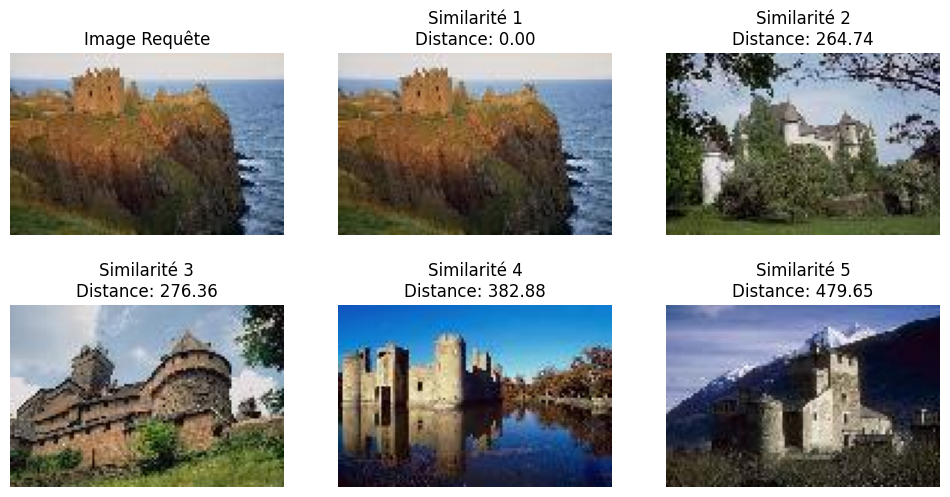

In [ ]:
base_image_path = '/content/drive/My Drive/CBIR_DataSet/obj_decoys/'

image_requete = '/content/drive/My Drive/CBIR_DataSet/img_requetes/ImageRequete.jpg'

index_matrix, image_names = CBIR_Indexation(base_image_path)

resultats = CBIR_Recherche(image_requete, index_matrix, image_names)

afficher_resultats(image_requete, resultats, base_image_path)


* **Interprétation des résultats**





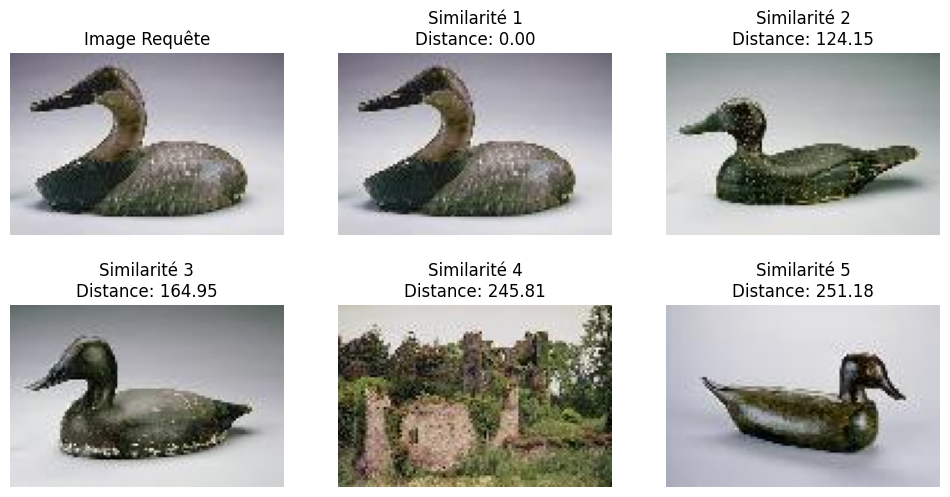

In [ ]:
base_image_path = '/content/drive/My Drive/CBIR_DataSet/obj_decoys/'

image_requete2 = '/content/drive/My Drive/CBIR_DataSet/img_requetes/ImageRequete2.jpg'

index_matrix, image_names = CBIR_Indexation(base_image_path)

resultats = CBIR_Recherche(image_requete2, index_matrix, image_names)

afficher_resultats(image_requete2, resultats, base_image_path)

* **Interprétation des résultats**





- The histogram-based method worked well to capture similarities in terms of dominant colors. The first images returned, depicting wooden ducks, are visually consistent with the query image, showing that **the histogram is effective when objects share similar hues**.

- **Limitations:** The appearance of an image of a ruin in the results shows that the histogram **does not account for shape or context**. This highlights a weakness in the method, as it compares only colors, leading to errors when very different objects share a similar color palette.

<h2>3.4	Texture-Based Search</h2>
Texture is very important information and is generally always present in images. It is widely used in CBIR systems.<br>
What we'll do now is:
<br>
1. Create a new texture descriptor of size 4 that will contain contrast, correlation, energy, and homogeneity.
These four features are commonly used in this type of system and represent statistical measures extracted from the Gray Level Co-occurrence Matrix (GLCM), also known as the spatial dependency matrix of gray levels. GLCM functions characterize the texture of an image by calculating the frequency at which pairs of pixels with specific values and in a specified spatial relationship occur within an image. This creates a GLCM matrix from which statistical measures are extracted. <br>
<br>
2. Modify the Python code to implement a CBIR system using a descriptor vector composed of color, histogram, and texture. Also, add the function "textureFeatures" that takes an image as input and returns the descriptor vector created from the texture. Then, the "getFeatures" function must be modified to concatenate the two descriptor vectors: one for color moments and one for histogram.<br>
<br>
3. Re-run the indexing with the color moments, histogram-based descriptor, and the texture descriptor. Then, perform the search and compare the results.

In [ ]:
import cv2
from skimage.feature import graycomatrix, graycoprops

def textureFeatures(img):
    img_gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

    glcm = graycomatrix(img_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return np.array([contrast, correlation, energy, homogeneity])

def getFeatures(img, fsize_moments=6, hist_size=8):
    moments = color_Moments(img)

    hsv_histogram = hsvHistogramFeatures(img, hist_size)

    texture = textureFeatures(img)
    return np.concatenate([moments, hsv_histogram, texture])

def CBIR_Indexation(base_image_path, fsize_moments=6, hist_size=8):
    index_matrix = []
    image_names = []

    for image_file in os.listdir(base_image_path):
        if image_file.endswith(('jpg', 'jpeg', 'png')):
            image_path = os.path.join(base_image_path, image_file)
            img = Image.open(image_path).convert('RGB')
            features = getFeatures(img, fsize_moments, hist_size)
            index_matrix.append(features)
            image_names.append(image_file)

    return np.array(index_matrix), image_names

def CBIR_Recherche(image_requete, index_matrix, image_names, fsize_moments=6, hist_size=8):
    img_req = Image.open(image_requete).convert('RGB')
    query_features = getFeatures(img_req, fsize_moments, hist_size)

    distances = []
    for i, features in enumerate(index_matrix):
        dist = np.linalg.norm(query_features - features)
        distances.append((image_names[i], dist))
    distances = sorted(distances, key=lambda x: x[1])

    return distances[:5]


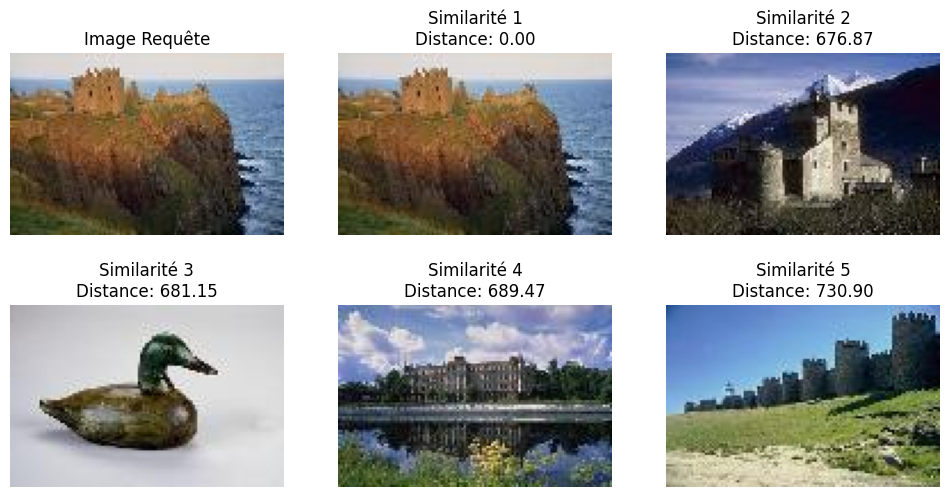

In [ ]:
base_image_path = '/content/drive/My Drive/CBIR_DataSet/obj_decoys/'

image_requete = '/content/drive/My Drive/CBIR_DataSet/img_requetes/ImageRequete.jpg'

index_matrix, image_names = CBIR_Indexation(base_image_path)

resultats = CBIR_Recherche(image_requete, index_matrix, image_names)

afficher_resultats(image_requete, resultats, base_image_path)


- The texture-based method effectively c**aptured the rough and natural textures of the castles and their surroundings**, particularly the stone and vegetation surfaces.
- **Limitations:** As with other approaches, the texture method does not account for semantic or shape details. The appearance of a duck in the results shows that the method is sensitive to similar textures without distinguishing the shape or nature of the objects.

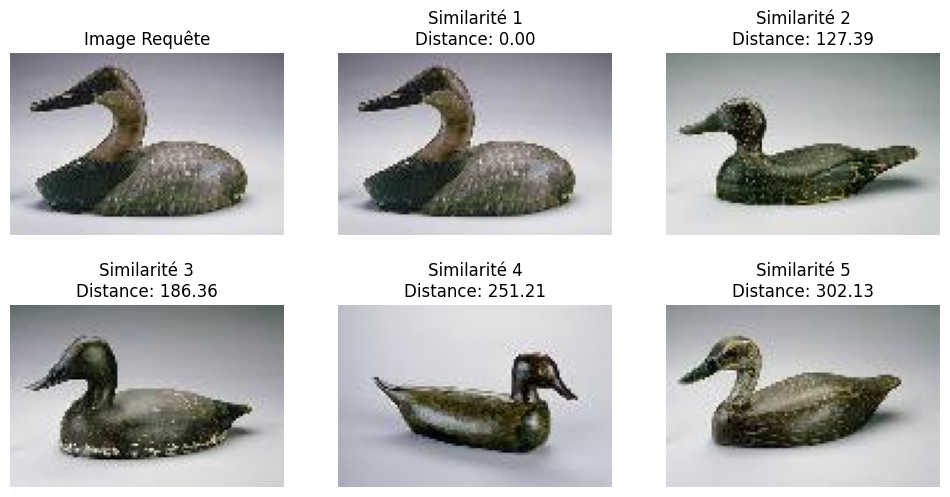

In [ ]:
base_image_path = '/content/drive/My Drive/CBIR_DataSet/obj_decoys/'

image_requete2 = '/content/drive/My Drive/CBIR_DataSet/img_requetes/ImageRequete2.jpg'

index_matrix, image_names = CBIR_Indexation(base_image_path)

resultats = CBIR_Recherche(image_requete2, index_matrix, image_names)

afficher_resultats(image_requete2, resultats, base_image_path)

* **Interprétation des résultats**





- The texture-based method effectively captured the rough and grainy surfaces of the duck. The results show that this approach works well for retrieving objects with similar surface textures.


<h2>3.5	Robustness to Geometric Transformations</h2>
The robustness of CBIR systems is tested in the presence of geometric transformations, namely translation, rotation, and scaling.








In [ ]:
from PIL import Image

def apply_translation(img, tx=20, ty=20):
    translated_img = img.transform(img.size, Image.AFFINE, (1, 0, tx, 0, 1, ty))
    return translated_img

def apply_rotation(img, angle=45):
    rotated_img = img.rotate(angle)
    return rotated_img

def apply_scaling(img, scale_factor=1.5):
    new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
    scaled_img = img.resize(new_size, Image.Resampling.LANCZOS)  # Correction ici
    return scaled_img

def test_robustness(image_requete, index_matrix, image_names, base_image_path):
    img_req = Image.open(image_requete).convert('RGB')

    img_translated = apply_translation(img_req, tx=30, ty=30)
    img_rotated = apply_rotation(img_req, angle=45)
    img_scaled = apply_scaling(img_req, scale_factor=1.2)

    for transformed_img, transformation_name in zip([img_translated, img_rotated, img_scaled],
                                                    ["Translation", "Rotation", "Scaling"]):
        transformed_img.save(f'transformed_{transformation_name}.jpg')

        resultats = CBIR_Recherche(f'transformed_{transformation_name}.jpg', index_matrix, image_names)

        print(f"Résultats après {transformation_name}:")
        afficher_resultats(f'transformed_{transformation_name}.jpg', resultats, base_image_path)


Résultats après Translation:


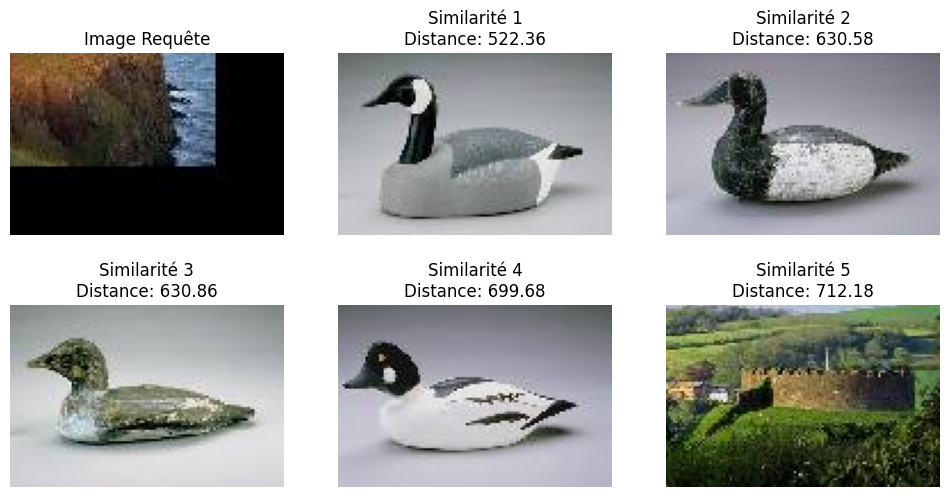

Résultats après Rotation:


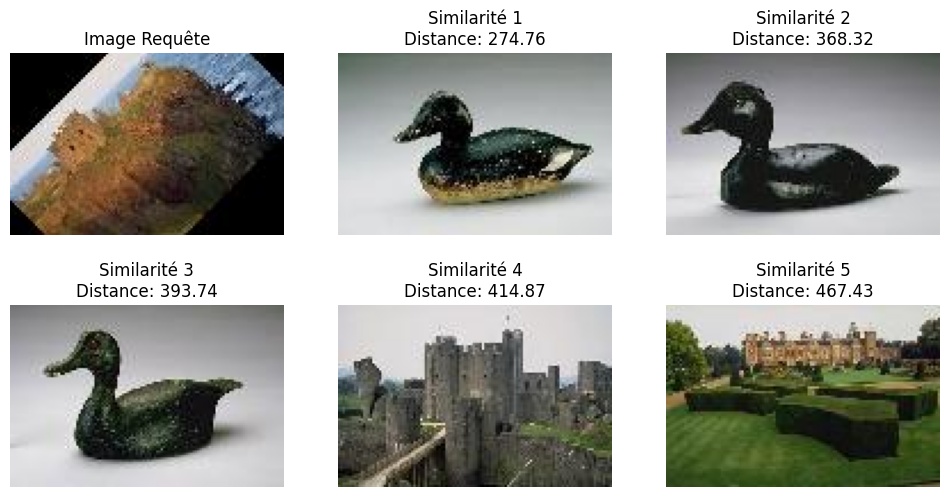

Résultats après Scaling:


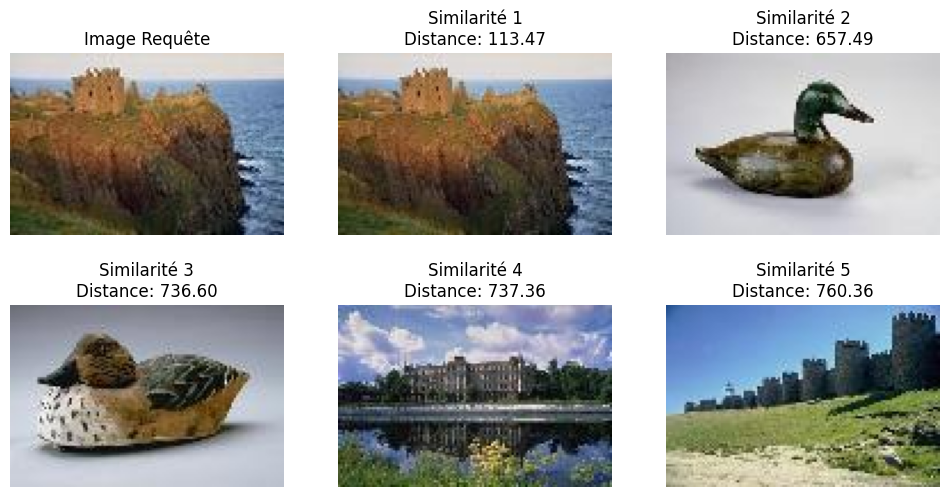

In [ ]:
base_image_path = '/content/drive/My Drive/CBIR_DataSet/obj_decoys/'

image_requete = '/content/drive/My Drive/CBIR_DataSet/img_requetes/ImageRequete.jpg'

index_matrix, image_names = CBIR_Indexation(base_image_path)

test_robustness(image_requete, index_matrix, image_names, base_image_path)


Résultats après Translation:


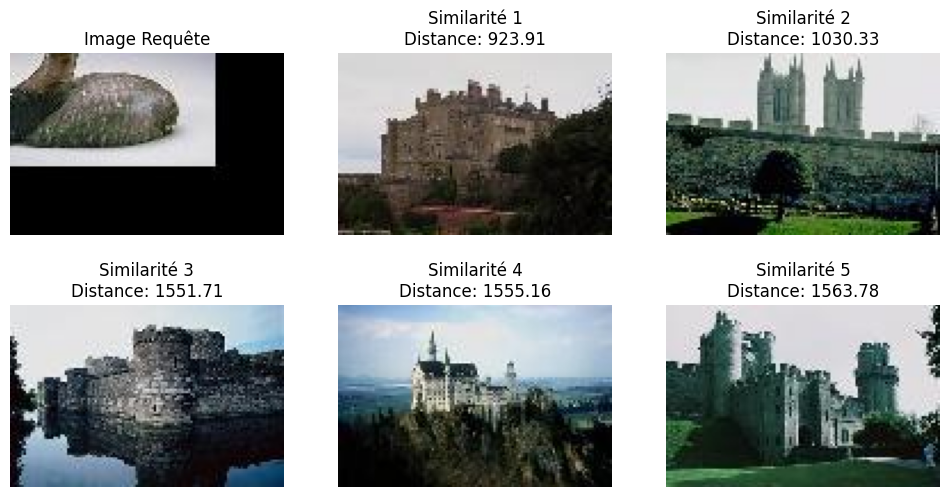

Résultats après Rotation:


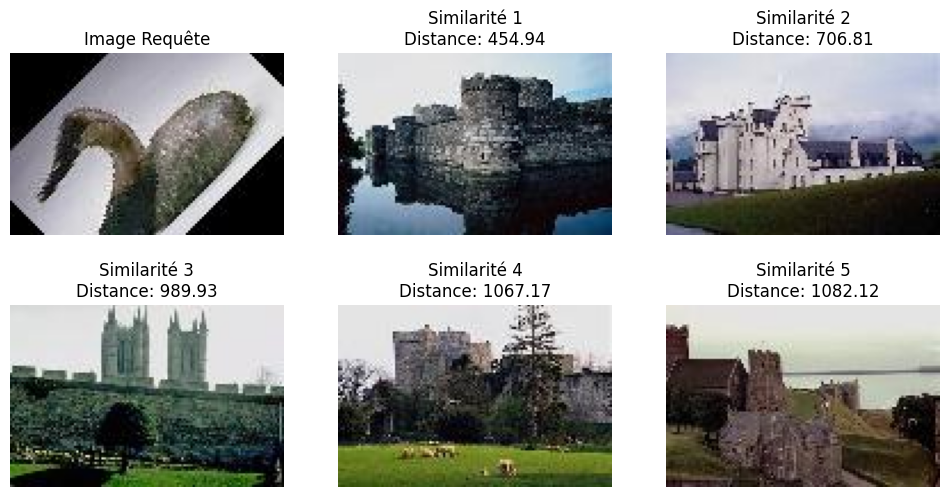

Résultats après Scaling:


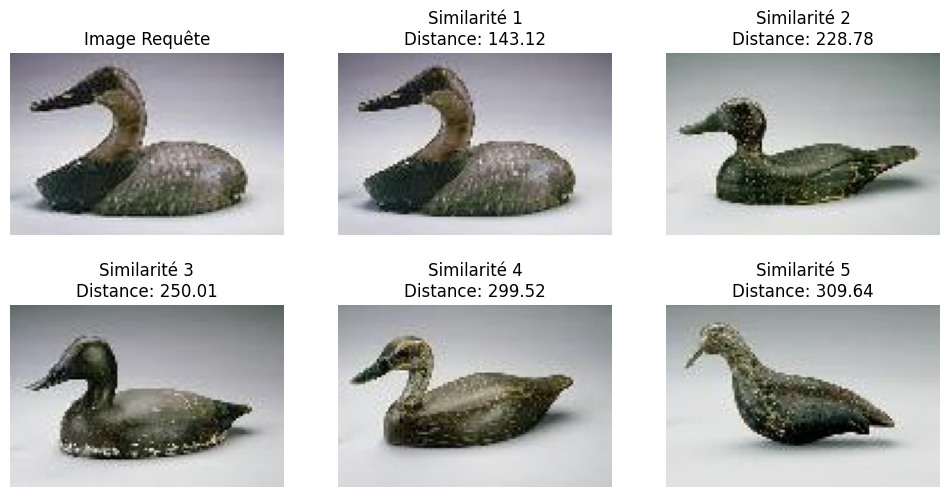

In [ ]:
base_image_path = '/content/drive/My Drive/CBIR_DataSet/obj_decoys/'

image_requete2 = '/content/drive/My Drive/CBIR_DataSet/img_requetes/ImageRequete2.jpg'

index_matrix, image_names = CBIR_Indexation(base_image_path)

test_robustness(image_requete2, index_matrix, image_names, base_image_path)


- **Translation and rotation** disrupt the system.

- **Robustness to scaling:** Scaling is relatively well handled. The query image is retrieved with a low distance, indicating that the system can tolerate size changes without significantly altering the results. However, the presence of incorrect objects in the results shows that the algorithm still relies heavily on color and texture-based descriptors.